In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qutip import * 
import os

# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
plt.rcParams.update({
    'text.usetex': True,              # Enable LaTeX for text rendering
    'font.family': 'serif',           # Use a serif font family
    'font.serif': 'Palatino',         # Set Palatino as the serif font
    'text.latex.preamble': r'\usepackage{amsmath}',
    'font.size': 20,                   # Font size for general text
    'axes.titlesize': 20,              # Font size for axis titles
    'axes.labelsize': 20,              # Font size for axis labels
    'xtick.labelsize': 20,             # Font size for x-axis tick labels
    'ytick.labelsize': 20,             # Font size for y-axis tick labels
    'legend.fontsize': 20,             # Font size for legends
    'figure.figsize': [8, 6],          # Size of the plot (width x height)
    'figure.autolayout': True,         # Automatic layout adjustment
    'savefig.format': 'svg',           # Default format for saving figures
    'figure.facecolor': 'none',        # Make the figure face color transparent
    'axes.facecolor': 'none',          # Make the axes face color transparent
    'savefig.transparent': True        # Save figures with transparent background
})

output_dir = r"C:\Users\leopo\OneDrive - UT Cloud\Uni\Semester_9\Master_thesis\Figures_From_Python"
os.makedirs(output_dir, exist_ok=True)

# allows for interactive plots
#%matplotlib notebook

$$
\displaystyle H = \hbar \sum_{i=1}^{N_{\text{atoms}}} \omega_0 \sigma_+^{(i)} \sigma_-^{(i)}
- \hbar \sum_{i,j=1}^{N_\text{{atoms}}} J_{i j} \sigma_+^{(i)} \sigma_-^{(j)}.
$$
$$
\displaystyle J_{i j} = \frac{\alpha}{|r_i-r_j|}.
$$

In [2]:
# Set the system parameters
n_rings = 2
n_chains = 2 # number of chains
N_atoms = n_chains * n_rings  # number of atoms

fixed_lam = 1.                # energysplitting, when ground state is set to 0
omega_0 = 2 * np.pi / fixed_lam # actually k_a
distance = 1 * fixed_lam # defining topology                                    0.1 <--

gamma_0 = .1   # decay rate
gamma_phi = .1 # dephasing rate

alpha = 1. # coupling strength of the dipoles       Fine structure const?
mu    = 1. # dipole strength
# evolution
t_max = 30

In [3]:
########################################               define the geometry                 #############################################
def chain_positions(distance, N_atoms):
    Pos = np.zeros((N_atoms, 3))
    for i in range(N_atoms):
        Pos[i, 2] = i * distance
    return Pos

def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0,              0,            1]])

def ring_positions(distance, n_chains):
    Pos = np.zeros((n_chains, 3))
    dphi = 2 * np.pi / n_chains
    if n_chains == 1:
        radius = 0
    else:
        radius = distance / 2 / np.sin(np.pi / n_chains)
    helper = np.array([radius, 0, 0])
    for i in range(n_chains):
        rotation_matrix = z_rotation(dphi * i)
        Pos[i] = np.matmul(rotation_matrix, helper)
    return Pos

def cyl_positions(distance, N_atoms, n_chains):
    Pos = np.zeros((N_atoms, 3))
    Pos_chain = chain_positions(distance, N_atoms // n_chains)
    Pos_ring = ring_positions(distance, n_chains)
    for i in range(n_chains):
        Pos[i * (N_atoms // n_chains): (i + 1) * (N_atoms // n_chains)] = Pos_chain + Pos_ring[i]
    return Pos

C:\Users\leopo\anaconda3\envs\Master\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


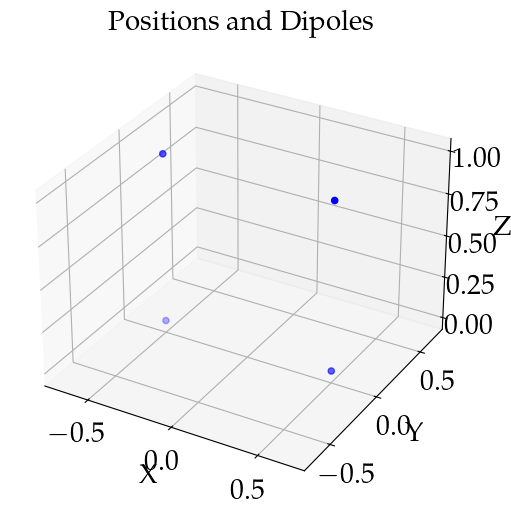

In [4]:
Pos = cyl_positions(distance, N_atoms, n_chains)

# Plotting 
fig = plt.figure(figsize=(8, 6)) 
ax = fig.add_subplot(111, projection='3d') 
# Plot the positions 
ax.scatter(Pos[:, 0], Pos[:, 1], Pos[:, 2], c='b', marker='o') 
ax.set_xlabel('X') 
ax.set_ylabel('Y') 
ax.set_zlabel('Z') 
ax.set_title('Positions and Dipoles')
ax.axis('equal')
plt.show()

In [5]:
# initial state
psiini = basis(N_atoms+1, 1)

'''k = np.pi / 4  # a single wavevector value

# Define the superposition state excited by a single mode with wavevector k
superposition_state = sum(
    np.exp(1j * k * np.linalg.norm(Pos[n])) * basis(N_atoms + 1, n) for n in range(1, 6)
)

# Normalize the state
psiini = superposition_state.unit()'''
psiini

Quantum object: dims=[[5], [1]], shape=(5, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]
 [0.]]

In [6]:
# Define the ground & the excited states
ground_state = basis(N_atoms + 1, 0)
excited_states = [basis(N_atoms + 1, i) for i in range(1, N_atoms + 1)]
sm_list = []
dip_op = 0
for i in range(N_atoms):
    op = ground_state * excited_states[i].dag()
    sm_list.append(op)
    dip_op += mu * op + mu * op.dag()

In [7]:
dip_op

Quantum object: dims=[[5], [5]], shape=(5, 5), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]

In [8]:
def Hamilton(distance, n_rings, n_chains):
    N_atoms = n_chains * n_rings
    Pos = cyl_positions(distance, N_atoms, n_chains)
    H = 0
    for a in range(N_atoms):
        for b in range(N_atoms):
            base = (sm_list[a].dag() * sm_list[b])
            if a != b:
                ra, rb = Pos[a, :], Pos[b, :]
                H += alpha / (np.linalg.norm(rb-ra))* base
            else:
                H +=  omega_0 * base # Diagonals except for |0><0|

    return H
    
H = Hamilton(distance, n_rings, n_chains)

H

Quantum object: dims=[[5], [5]], shape=(5, 5), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.         0.         0.         0.         0.        ]
 [0.         6.28318531 1.         1.         0.70710678]
 [0.         1.         6.28318531 0.70710678 1.        ]
 [0.         1.         0.70710678 6.28318531 1.        ]
 [0.         0.70710678 1.         1.         6.28318531]]

## Single case

$$
C_{\text{decay}}^{(i)} = \sqrt{\gamma_0} \sigma_-^{(i)} \quad
C_{\text{dephase}}^{(i)} = \sqrt{\gamma_\phi} \sigma_z^{(i)}
$$

## Collective case
$$
C_{\text{decay}} = \sum_{n=1}^{N_{\text{atoms}}} C_{\text{decay}}^{(i)} \quad
C_{\text{dephase}} = \sum_{n=1}^{N_\text{atoms}} C_{\text{dephase}}^{(i)}
$$

In [9]:
# Jump / Expect Operators

'''# TRASH DOESNT DO ANYTHING?c_op1 = [np.sqrt(gamma_0) * sum(sm_list)]                                       # COLLECTIVE DECAY??? doesnt work?
# TRASH DOESNT DO ANYTHING?c_op3 = [np.sqrt(gamma_phi) * sum(commutator(sm.dag(), sm) for sm in sm_list)]  # COLLECTIVE DEPHASNG'''

# Define the decay collapse and dephasing operator for each spin
c_op2 = [np.sqrt(gamma_0) * sm for sm in sm_list]                                                          # EVERY ATOM DECAYS on its own
c_op4 = [np.sqrt(gamma_phi) * commutator(sm.dag(), sm) for sm in sm_list]                                  # EVEY ATOM DEPHASES

c_op_list = c_op2 + c_op4

e_op_list = [basis(N_atoms+1, i) * basis(N_atoms+1, i).dag() for i in range(0,N_atoms+1)] # 

<Result
  Solver: mesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.0010035037994384766
    preparation time: 0.0011792182922363281
    run time: 6.599331378936768
    solver: 'Master Equation Evolution'
    num_collapse: 8
  Time interval: [0.0, 30.0] (30000 steps)
  Number of e_ops: 5
  State not saved.
>


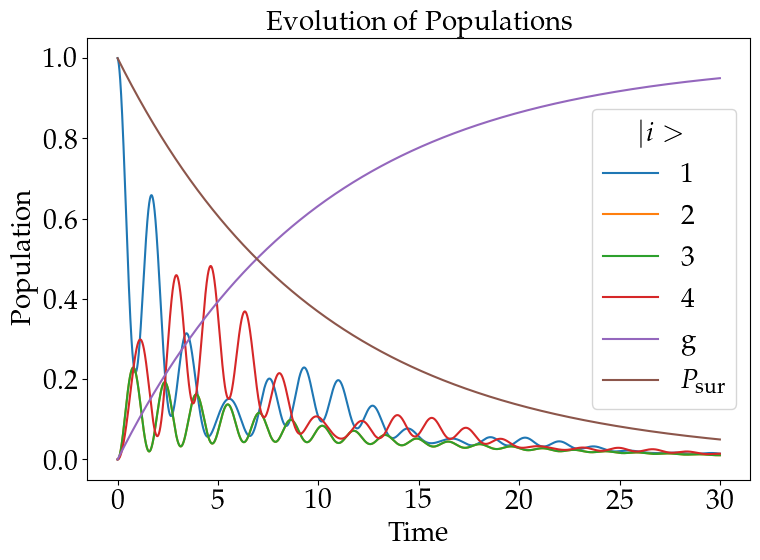

In [10]:
# evolution
times = np.linspace(0, t_max, t_max * 1000) # list of times

result = mesolve(H, psiini, times, c_ops = c_op_list, e_ops = e_op_list) #, options={"store_states": True}
print(result)
# Plot the expectation values
plt.figure()
for i in range(1, N_atoms+1):
    label = str(i) if i < 5 else None
    plt.plot(times, result.expect[i], label=label)
plt.xlabel("Time")
plt.ylabel("Population")
Psur = sum(result.expect[i] for i in range(1,N_atoms+1)) 
plt.plot(times, result.expect[0], label="g")
plt.plot(times, Psur, label= r"$P_{\text{sur}}$")
plt.legend(title="$|i>$")

plt.title("Evolution of Populations")
plt.show()

In [11]:
# y1: 2D array with shape (len(times), N_atoms) 
y1 = np.array(result.expect[1:]).T # neglect ground state

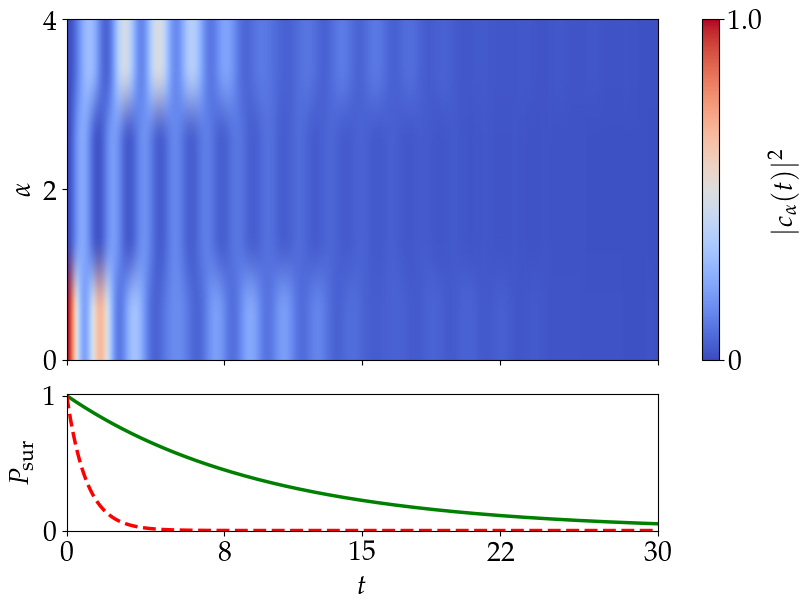

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2.5, 1]}, constrained_layout=True, figsize=(8,6))

im = ax1.imshow(y1.T, aspect='auto', origin='lower', cmap='coolwarm', extent=[0, t_max, 0, N_atoms])
yticks = [0] + [i * n_rings for i in range(1, n_chains + 1)] 
ax1.set_yticks(yticks)

ax2.plot(times, Psur, color='green', linewidth=2.5, label='collective')
ax2.plot(times, np.exp(-times), 'r--', linewidth=2.5, label='1 atom')

max_value = np.max(y1)
cbar = fig.colorbar(im, ax=ax1, label=r'$ \vert c_{\alpha}(t)\vert ^2$')
cbar.set_ticks([0, max_value])
cbar.set_ticklabels([r'0', f'{max_value:.1f}'])

ax2.set_ylim(0, 1.01)
ax2.set_xticks([0, round(t_max/4), round(t_max/2), round(3* t_max/4), t_max])
ax2.set_xticklabels(['0', f'{round(t_max/4)}', f'{round(t_max/2)}', f'{round(3*t_max/4)}', f'{round(t_max)}'])
#ax2.set_yticks([0, Psur[-1], 1])
#ax2.set_yticklabels(['0', f'{Psur[-1]:.2f}', '1'])
ax1.set_ylabel(r'$\alpha$')
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$P_{\text{sur}}$')
plt.show()

In [13]:
def third_order_polarization(E, t, tau, T):
    """
    Calculate the third-order polarization signal.

    Parameters:
    E (function): External electric field as a function of time.
    t (float): Detection time.
    tau (float): Coherence time.
    T (float): Waiting time.

    Returns:
    float: Third-order polarization signal.
    """
    # Define the Heaviside function
    def heaviside(x):
        return 1 if x >= 0 else 0

    # Define the dipole response function R(t1, t2, t3)
    def R(t1, t2, t3):
        return heaviside(t1) * heaviside(t2) * heaviside(t3)

    # Integrate the third-order dipole moment
    integral = 0
    for t1 in np.linspace(-np.inf, np.inf, 100):
        for t2 in np.linspace(-np.inf, np.inf, 100):
            for t3 in np.linspace(-np.inf, np.inf, 100):
                integral += R(t1, t2, t3) * E(t - t3) * E(t - t3 - t2) * E(t - t3 - t2 - t1)

    # Calculate the third-order polarization signal
    P3 = integral
    Esig = np.gradient(P3, t)

    return Esig

# Example usage
def electric_field(t):
    return np.exp(-t**2)

t = 0
tau = 1
T = 1
signal = third_order_polarization(electric_field, t, tau, T)
print(signal)



E0 = [10, 10, 1] #
omegas = [omega_0, omega_0, omega_0]
Deltats = [1, 1, 1]

C:\Users\leopo\anaconda3\envs\Master\Lib\site-packages\numpy\_core\function_base.py:168: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\leopo\anaconda3\envs\Master\Lib\site-packages\numpy\_core\function_base.py:178: RuntimeWarning: invalid value encountered in add
  y += start


KeyboardInterrupt: 

In [14]:
def El_field(j, t):
    E = 1 / np.sqrt(2) * (np.array(1,1,0) * E0[j] * 
                        heaviside(Deltats[j] - np.abs(t)) * np.cos(np.pi*t/(2*Deltats[j]))**2 * cos(omegas[j] * t + phi[j]))
    return E

In [17]:
from pyscf import gto, dft, tddft

# Define the molecule
mol = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='sto-3g')

# Perform DFT calculation for the ground state
mf = dft.RKS(mol)
mf.xc = 'PBE'  # Choose exchange-correlation functional
mf.kernel()

# Perform TDDFT calculation for the excited states
td = tddft.TDDFT(mf)
td.nstates = 5  # Number of excited states to calculate
td.kernel()

# Print the excitation energies
print('Excitation energies (eV):', td.e)

ModuleNotFoundError: No module named 'pyscf'

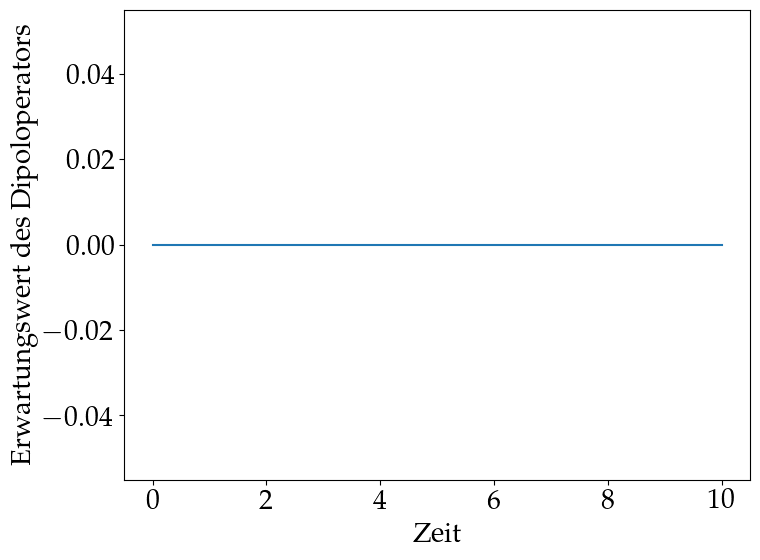

In [16]:
# Definiere die Parameter
N = 2  # Anzahl der Zustände
H = Qobj([[0, 1], [1, 0]])  # Hamiltonian
gamma = 0.1  # Dissipationsrate

# Definiere den Dipoloperator
D = Qobj([[0, 1], [1, 0]])

# Definiere die Lindblad-Operatoren
L = [np.sqrt(gamma) * Qobj([[0, 1], [0, 0]])]

# Initialisiere die Dichte-Matrix
rho0 = basis(N, 0) * basis(N, 0).dag()

# Zeitentwicklung
tlist = np.linspace(0, 10, 100)
result = mesolve(H, rho0, tlist, L, [D])

# Plotten der Erwartungswerte des Dipoloperators
import matplotlib.pyplot as plt
plt.plot(tlist, result.expect[0])
plt.xlabel('Zeit')
plt.ylabel('Erwartungswert des Dipoloperators')
plt.show()
